# IMAGEN Analysis #
First thing to do is read in the 'safe' training data file, which contains task and life history data. The model fit parameters will be read in after this.

## Table of Contents: ##
* [Summary Stats for MID and SST Params](#summary stats for mid and sst params)
* [Mean Shift and Normalize](#mean shift and normalize)
* [Shuffle Test](#Shuffle Test)
* [Further Data Subdivision](#further data subdivision)
* [Missing Data: Age 14](#missing data age 14)
* [Impute Features](#impute features)
* [Clean Up Features](#clean up features)
* [Misc. Correlations](#misc correlations)
* [Canonical Correlations Analysis: Age 14](#canonical correlations analysis age 14)
* [Principle Components Analysis](#principle components analysis)
* [CCA Across Baseline and Follow Up](#cca across baseline and follow up)
* [CCA from Age 14 Tasks to Age 18 Survey](#cca from age 14 tasks to age 18 survey)
* [Gaussian Mixture Model](#gaussian mixture model)

## Read in Subject Data ##

In [1]:
# Read the training data file
fname    <- '/home/dan/documents/lncc/synthetic data/sst_round_2/safe_test_data.csv'
df_train <- read.csv(file=fname, header=TRUE, sep=',');

# Read the training data file
fname   <- '/home/dan/documents/lncc/synthetic data/sst_round_2/safe_train_data.csv'
df_test <- read.csv(file=fname, header=TRUE, sep=',');

# Might want to keep track separate copies as well as merged which is why I'm doing it this way...
cleanup <- function(dframe){
    # These fields don't need to go into analysis:
    drop_flds <- c('Site_14'   , 'Group_14'      , 'Label_14_x', 'Label_14_y', 'Gender_14_x', 'Gender_14_y',
                   'QR_flag_14', 'Reliability_16', '', 'espad_6.life.nic_14', 'espad_8a.alc.life_14', 
                   'agn_mean_correct_latency_neutral_14', 'agn_total_omissions_neutral_14')

    # Drop them:
    dframe <- dframe[,!(names(dframe) %in% drop_flds)]

    # Convert Age_14 data to days
    # Don't know exact conversion since don't know years, but this is fine
    #dframe['Age_14'] = dframe['Age_14']*365.24
}

# Clean up data frames:
df_train <- cleanup(df_train)
df_train['Age_14'] = df_train['Age_14']*365.24

df_test  <- cleanup(df_test)
df_test['Age_14'] = df_test['Age_14']*365.24

# Stack them to create a big copy
raw_df <- rbind(df_train, df_test)
raw_df['Age_14'] = raw_df['Age_14']*365.24

# Measures that exist for age 16: Currently not being used.
features_16 <- c('Age.for.timestamp_16', 'X6.life.nic_16', 'X8a.life.alc_16', 'life_amphet_16', 'life_anabolic_16',
    'life_coke_16', 'life_crack_16', 'life_ghb_16', 'life_glue_16', 'life_hash_16', 'life_heroin_16',
    'life_ketamine_16', 'life_lsd_16', 'life_mdma_16', 'life_mushrooms_16', 'life_tranq_16', 'log10.k._16')

#### Define a Function for Reading SSTParameter Files #### 

In [2]:
read_sst_params <- function(filename, subjects, skip){
    sst_params_raw   <- read.csv(file=filename, header=TRUE, sep=';');

    # What parameters are being read?
    sst_params_names <- c('mu_go_subj' ,'mu_stop_subj' ,'sigma_go_subj', 'sigma_stop_subj',
                          'tau_go_subj','tau_stop_subj','p_tf_subjpt')

    # Set up the dataframe to accept mean parameter values.
    sst_params           <- data.frame(matrix(ncol=7, nrow=198))
    colnames(sst_params) <- sst_params_names 
    trace_means          <- colMeans(sst_params_raw[2000:3000,])
    sst_params['Subject']<- subjects

    # Save the parameters:
    for (subj_num in 1:198) {
        for (param_name in sst_params_names) {

            param_name_long <- paste(param_name,'.',subj_num, sep='')

            # Currently missing some data...
            if (any(subj_num == 157:185) & skip){            
            } else{
                sst_params[subj_num, param_name] <- trace_means[param_name_long]
            }
        }
    }

    return(sst_params)
}

Read the SST Files and concatenate the sst data.

In [3]:
# Read the SST parameters' file:
sst_params_file  <- '/home/dan/documents/lncc/sst_data_train/parameters1.csv'
subjects <- df_train['Subject']

sst_params_train <- read_sst_params(sst_params_file, subjects, TRUE)

# Read the SST parameters' file:
sst_params_file  <- '/home/dan/documents/lncc/sst_data_test_100_200/parameters1.csv'
subjects <- df_test['Subject']

sst_params_test <- read_sst_params(sst_params_file, subjects, FALSE)

# Read the SST parameters' file:
sst_params_file  <- '/home/dan/documents/lncc/sst_data_test_0_50/parameters1.csv'
sst_params_test2 <- read_sst_params(sst_params_file, subjects, FALSE)

sst_params_test <- rbind(sst_params_test2[1:50,], sst_params_test[51:198,])
sst_params      <- rbind(sst_params_train, sst_params_test)
dim(sst_params)
dim(raw_df)

[1] 396   8

[1] 396  92

The model-fit parameters get read in here for the SST and MID tasks.

In [4]:
#raw_df['Subject'] == sst_params['Subject']

In [5]:
# Read the MID fit file in:
mid_params_file <- '/home/dan/documents/lncc/From Nick Jan 20/MIDT_SubjectFits_BL_All.csv'
mid_params_raw  <- read.csv(file=mid_params_file, header=TRUE, sep=',');

#
mid_params       <- data.frame(matrix(ncol=12, nrow=dim(unique(mid_params_raw['Subject']))[1]))
mid_params_names <- c('Target Duration Coeff', 'Target is Left Coeff', 'Cue is Rewarded Coeff',
                      'Cue is High Reward Coeff', 'StDev of 1/RT', 'Intercept')
mid_params_type  <- c('Expectation', 'Variance')

colnames(mid_params) <- c( outer( mid_params_names, c('Expectation', 'Variance'), FUN=paste ,sep=" "))

mid_params['Subject'] <- unique(mid_params_raw['Subject'])
for (row in  1:dim(mid_params_raw)[1]) {
    subject <- mid_params_raw[row, 'Subject']
    param   <- mid_params_raw[row, 'Parameter']
    
    subj_msk <- mid_params['Subject'] == subject
        
    mid_params[subj_msk, paste(param,'Expectation',sep=' ')] <- mid_params_raw[row,'Expectation']
    mid_params[subj_msk, paste(param,'Variance'   ,sep=' ')] <- mid_params_raw[row,'Variance'   ]
}
tmp <- merge(sst_params, mid_params, by="Subject")


In [6]:
#head(mid_params)
#tail(mid_params)
#head(tmp)
#tail(tmp)

In [7]:
dim(sst_params)
dim(tmp)
dim(raw_df)

raw_df <- merge(raw_df, tmp, by="Subject", all=TRUE)
#raw_df_backup <- raw_df
print(dim(raw_df))

[1] 396   8

[1] 354  20

[1] 396  92

[1] 396 111


In [8]:
head(raw_df)
tail(raw_df)

Subject,X,Sex_best_M0_14,Age_14,PDS_14,Hand_14,IQ_PR_14,IQ_VC_14,GB_SSRT_14,All_Alc_14,⋯,Cue is Rewarded Coeff Expectation,Cue is High Reward Coeff Expectation,StDev of 1/RT Expectation,Intercept Expectation,Target Duration Coeff Variance,Target is Left Coeff Variance,Cue is Rewarded Coeff Variance,Cue is High Reward Coeff Variance,StDev of 1/RT Variance,Intercept Variance
106601,629,0,1863602,3,0,125,105,233.00,0,⋯,-0.2657257,0.06950013,12.5926897,4.241146,0.012310619,0.02317119,0.02245341,0.005103826,1.369276429,0.18490910
240546,1146,0,1932970,3,1,131,140,255.50,0,⋯,-0.4236054,0.06951926,0.6819648,4.484762,0.009166669,0.01279684,0.01375230,0.004074825,0.004363782,0.01225476
297685,939,1,1932970,4,1,104,87,202.46,4,⋯,-0.3622713,0.09996765,0.7610062,4.598624,0.009276014,0.01361784,0.01774517,0.004698882,0.005795328,0.01487051
469693,1234,1,1963652,4,1,112,117,275.00,2,⋯,-0.2533179,0.06586994,2.3535806,4.754553,0.012409335,0.02197612,0.02462890,0.005247020,0.054940526,0.07139206
556983,11,1,1888948,4,1,NA,NA,246.83,5,⋯,-0.2440253,0.05595719,0.7313296,3.803053,0.012638648,0.01373604,0.01379205,0.004504593,0.004530396,0.01335244
613223,732,0,1982328,3,1,125,109,272.25,0,⋯,-0.3234227,0.07946278,1.0278398,4.329587,0.010262951,0.01828291,0.01690626,0.005396271,0.009126296,0.02259464


,Subject,X,Sex_best_M0_14,Age_14,PDS_14,Hand_14,IQ_PR_14,IQ_VC_14,GB_SSRT_14,All_Alc_14,⋯,Cue is Rewarded Coeff Expectation,Cue is High Reward Coeff Expectation,StDev of 1/RT Expectation,Intercept Expectation,Target Duration Coeff Variance,Target is Left Coeff Variance,Cue is Rewarded Coeff Variance,Cue is High Reward Coeff Variance,StDev of 1/RT Variance,Intercept Variance
391,97707135,1142,0,1948978,4,0,98,136,170.00,3,⋯,-0.2673369,0.05159350,0.3583238,4.030312,0.007784292,0.007423456,0.02556838,0.003100318,0.001559281,0.005179175
392,98485091,127,0,1844926,3,1,119,136,180.96,0,⋯,-0.1882584,0.08111696,0.7125781,4.569363,0.006525600,0.013141172,0.01566981,0.004494127,0.004862013,0.012892260
393,98562537,936,1,1886280,4,NA,98,103,218.53,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
394,98929068,128,1,1852930,5,1,119,134,185.40,5,⋯,-0.2828532,0.05669813,0.7361842,4.209195,0.009848374,0.015035290,0.01281290,0.004378411,0.005057389,0.014897083
395,99616225,1145,1,1956982,4,1,79,97,244.00,1,⋯,-0.2400976,0.07751707,0.9188065,4.259485,0.010454291,0.016535043,0.01884017,0.004697214,0.008340715,0.021515658
396,99875982,937,1,1910292,4,1,117,93,229.93,1,⋯,-0.5322723,0.06837958,0.6792469,3.886623,0.009380697,0.014024365,0.02043308,0.004390745,0.005007170,0.013732381


Specific subsets of the features available get selected here for use.

In [9]:
# Task data at age 14:
features_14_task_raw <- c('IQ_PR_14', 'IQ_VC_14', 'GB_SSRT_14',
       'agn_mean_correct_latency_negative_14',
       'agn_mean_correct_latency_positive_14',
       'agn_total_omissions_negative_14',
       'agn_total_omissions_positive_14',
       'cgt_delay_aversion_14',
       'cgt_deliberation_time_14',
       'cgt_quality_of_decision_making_14',
       'cgt_overall_proportion_bet_14',
       'cgt_risk_adjustment_14',
       'cgt_risk_taking_14',
       'prm_percent_correct_14',
       'rvp_a_14',
       'swm_between_errors_14',
       'swm_strategy_14',
       'log10.k._14', setdiff(colnames(sst_params),'Subject'), setdiff(colnames(mid_params),'Subject'))


features_14_task <- c('IQ_PR_14', 'IQ_VC_14', 'GB_SSRT_14',
       'agn_mean_cor_lat_neg_14',
       'agn_mean_cor_lat_pos_14',
       'agn_num_omis_neg_14',
       'agn_num_omis_pos_14',
       'cgt_delay_avers_14',
       'cgt_deliberation_14',
       'cgt_quality_14',
       'cgt_prop_bet_14',
       'cgt_risk_adjust_14',
       'cgt_risk_taking_14',
       'prm_perc_cor_14',
       'rvp_a_14',
       'swm_btwn_errs_14',
       'swm_strategy_14',
       'log10.k._14',
       'mu_go_14', 'mu_stop_14', 'sigma_go_14','sigma_stop_14','tau_go_14','tau_stop_14','p_tf_14',
       'mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
       'mu_high_rewarded_co_14', 'mu_std_inv_rt_14', 'mu_int_14',
       'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
       'sig_high_rewarded_co_14','sig_std_inv_rt_14','sig_int_14')

# Survey data at age 14:
#features_14_survey_raw <- c('Sex_best_M0_14', 'Age_14', 'PDS_14','All_Alc_14', 'All_Nic_14',
#       'espad_life_amphet_14',
#       'espad_life_anabolic_14',
#       'espad_life_coke_14',
#       'espad_life_crack_14',
#       'espad_life_ghb_14',
#       'espad_life_glue_14',
#       'espad_life_hash_14',
#       'espad_life_heroin_14',
#       'espad_life_ketamine_14',
#       'espad_life_lsd_14',
#       'espad_life_mdma_14',
#       'espad_life_mushrooms_14',
#       'espad_life_narcotic_14',
#       'espad_life_tranq_14')

features_14_survey_raw <- c('Sex_best_M0_14', 'PDS_14','All_Alc_14', 'All_Nic_14',
       'espad_life_amphet_14',
       'espad_life_coke_14',
       'espad_life_crack_14',
       'espad_life_ghb_14',
       'espad_life_glue_14',
       'espad_life_hash_14',
       'espad_life_ketamine_14',
       'espad_life_lsd_14',
       'espad_life_mushrooms_14',
       'espad_life_narcotic_14')

#features_14_survey <- c(
#       'bio_sex_14' , 'age_14'      , 'pds_14'   ,
#       'alc_14'     , 'nic_14'      , 'amphet_14',
#       'anabolic_14', 'coke_14'     , 'crack_14' ,
#       'ghb_14'     , 'glue_14'     , 'hash_14'  ,
#       'heroin_14'  , 'ketamine_14' , 'lsd_14'   ,
#       'mdma_14'    , 'mushrooms_14', 'narc_14'  ,
#       'tranq_14')

features_14_survey <- c(
       'bio_sex_14' , 'pds_14'   ,
       'alc_14'     , 'nic_14'      , 'amphet_14',
       'coke_14'     , 'crack_14' ,
       'ghb_14'     , 'glue_14'     , 'hash_14'  ,
       'ketamine_14' , 'lsd_14'   ,
       'mushrooms_14', 'narc_14'
       )
# Low nums:
#'Life.GHB_18','Life.tranq_18','Life.glue_18'
#'anabolic_14','mdma_14','tranq_14','heroin_14'

# 
features_18_task <- c('log10.k._18', 'agn_mean_correct_latency_negative_18', 'agn_mean_correct_latency_neutral_18',
    'agn_mean_correct_latency_positive_18', 'agn_total_omissions_negative_18', 'agn_total_omissions_neutral_18',
    'agn_total_omissions_positive_18', 'cgt_delay_aversion_18', 'cgt_deliberation_time_18', 
    'cgt_overall_proportion_bet_18', 'cgt_quality_of_decision_making_18', 'cgt_risk_adjustment_18',
    'cgt_risk_taking_18', 'prm_percent_correct_18', 'rvp_a_18', 'swm_between_errors_18', 'swm_strategy_18')
    

#features_18_survey <- c('age_18', 'X6.life.nic_18', 'X8a.life.alc_18', 'Life.amph_18', 'Life.anab_18',
#    'Life.coke_18', 'Life.crack_18', 'Life.hash.thc_18', 'Life.heroin_18', 'Life.GHB_18', 'Life.glue_18', 
#    'Life.ketamine_18', 'Life.lsd_18', 'Life.MDMA_18', 'Life.mushrooms_18', 'Lif.narc_18', 'Life.tranq_18')

features_18_survey <- c('X6.life.nic_18', 'X8a.life.alc_18', 'Life.amph_18', 'Life.anab_18',
    'Life.coke_18', 'Life.crack_18', 'Life.hash.thc_18', 'Life.heroin_18',
    'Life.ketamine_18', 'Life.lsd_18', 'Life.MDMA_18', 'Life.mushrooms_18', 'Lif.narc_18')


n_feat_task   <- length(features_14_task)
n_feat_survey <- length(features_14_survey)

for (i in 1:n_feat_task){
    old_name <- features_14_task_raw[[i]]
    new_name <- features_14_task[[i]]
    colnames(raw_df)[colnames(raw_df) == old_name] <- new_name
}
for (i in 1:n_feat_survey){
    old_name <- features_14_survey_raw[[i]]
    new_name <- features_14_survey[[i]]
    names(raw_df)[names(raw_df) == old_name] <- new_name
}

In [10]:
head(raw_df['Subject'])

Subject
106601
240546
297685
469693
556983
613223


In [11]:
#head(raw_df[colnames(mid_params)])
#tail(raw_df[colnames(mid_params)])

In [12]:
head(raw_df[c('mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
       'mu_high_rewarded_co_14', 'mu_int_14',
       'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
       'sig_high_rewarded_co_14')])
tail(raw_df[c('mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
       'mu_high_rewarded_co_14', 'mu_int_14',
       'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
       'sig_high_rewarded_co_14')])

mu_targ_dur_co_14,mu_targ_left_co_14,mu_rewarded_co_14,mu_high_rewarded_co_14,mu_int_14,sig_targ_dur_co_14,sig_targ_left_co_14,sig_rewarded_co_14,sig_high_rewarded_co_14
0.08335248,-0.02730878,-0.2657257,0.06950013,4.241146,0.012310619,0.02317119,0.02245341,0.005103826
0.08085611,-0.16202672,-0.4236054,0.06951926,4.484762,0.009166669,0.01279684,0.01375230,0.004074825
0.06109435,-0.04839415,-0.3622713,0.09996765,4.598624,0.009276014,0.01361784,0.01774517,0.004698882
0.07008690,-0.04046632,-0.2533179,0.06586994,4.754553,0.012409335,0.02197612,0.02462890,0.005247020
0.08141336,-0.04197246,-0.2440253,0.05595719,3.803053,0.012638648,0.01373604,0.01379205,0.004504593
0.11635481,0.10722669,-0.3234227,0.07946278,4.329587,0.010262951,0.01828291,0.01690626,0.005396271


,mu_targ_dur_co_14,mu_targ_left_co_14,mu_rewarded_co_14,mu_high_rewarded_co_14,mu_int_14,sig_targ_dur_co_14,sig_targ_left_co_14,sig_rewarded_co_14,sig_high_rewarded_co_14
391,0.16248094,-0.11970542,-0.2673369,0.05159350,4.030312,0.007784292,0.007423456,0.02556838,0.003100318
392,0.09819955,-0.05517000,-0.1882584,0.08111696,4.569363,0.006525600,0.013141172,0.01566981,0.004494127
393,NA,NA,NA,NA,NA,NA,NA,NA,NA
394,0.06209210,-0.24061456,-0.2828532,0.05669813,4.209195,0.009848374,0.015035290,0.01281290,0.004378411
395,0.12501219,-0.06833923,-0.2400976,0.07751707,4.259485,0.010454291,0.016535043,0.01884017,0.004697214
396,0.04816559,-0.11616229,-0.5322723,0.06837958,3.886623,0.009380697,0.014024365,0.02043308,0.004390745


In [13]:
raw_df <- raw_df[complete.cases(raw_df[,'mu_go_14']),]
dim(raw_df)

[1] 284 111

## Summary Stats for MID and SST Params  <a class="anchor" id="summary stats for mid and sst params"></a> ##

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 560 rows containing non-finite values (stat_bin).”

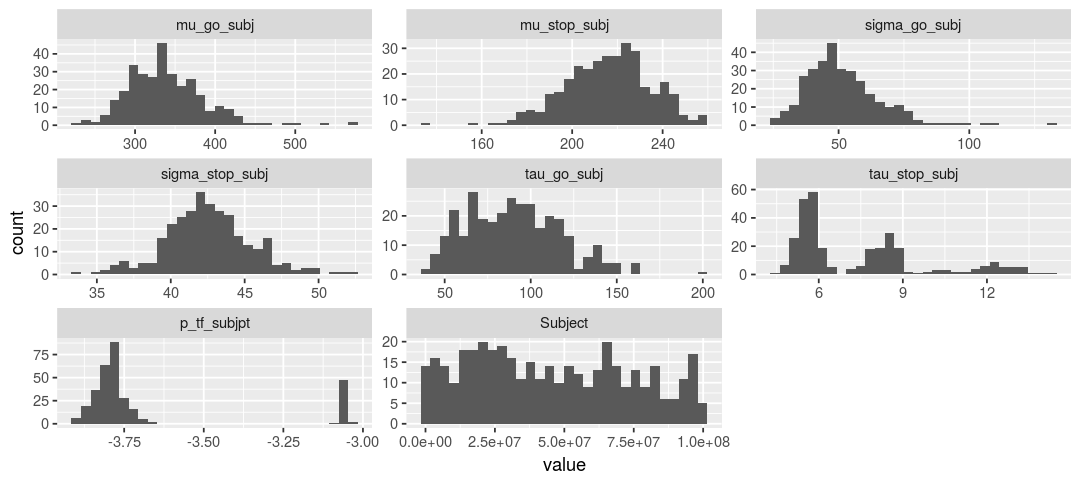

In [14]:
library(ggplot2)
library(reshape2)

d <- melt(sst_params)
options(repr.plot.width=9, repr.plot.height=4)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

## Outlier Removal <a class="anchor" id="Outlier Removal"></a> ##

In [15]:
remove_outliers  <- function(dframe, feat_list, thresh) {
    
    for (i in 1:length(feat_list)){
        feature <- feat_list[[i]]
        
        var   <- dframe[feature]
        stdev <- apply(var, 2, sd, na.rm=TRUE)
        dmean <- apply(var, 2, mean, na.rm=TRUE)
        dmed  <- apply(var, 2, median, na.rm=TRUE)

        outmsk <- apply(var, 2, (function (x) ifelse(abs(dmed-x) < thresh*stdev | is.na(x) ,FALSE ,TRUE)))        

        if (sum(outmsk) >0) {
            print(paste('Removing ', toString(sum(outmsk)), ' points from ', feature))
            print(dframe[feature][outmsk])
            cat('\n')

            dframe[feature][outmsk] <- NA
        }
    }
    return(dframe)
}

In [16]:
raw_df <- remove_outliers(raw_df, features_14_task , 4)

[1] "Removing  1  points from  IQ_VC_14"
[1] 57

[1] "Removing  1  points from  agn_mean_cor_lat_neg_14"
[1] 1087

[1] "Removing  1  points from  cgt_delay_avers_14"
[1] -1

[1] "Removing  4  points from  cgt_deliberation_14"
[1] 6397.535 6218.615 5050.476 5364.708

[1] "Removing  1  points from  cgt_quality_14"
[1] -1

[1] "Removing  1  points from  cgt_prop_bet_14"
[1] -1

[1] "Removing  1  points from  cgt_risk_taking_14"
[1] -1

[1] "Removing  5  points from  prm_perc_cor_14"
[1] 58.33333 58.33333 41.66667 58.33333 58.33333

[1] "Removing  1  points from  rvp_a_14"
[1] -1

[1] "Removing  3  points from  mu_go_14"
[1] 573.0557 566.9468 536.9346

[1] "Removing  1  points from  mu_stop_14"
[1] 136.8066

[1] "Removing  2  points from  sigma_go_14"
[1] 130.2769 109.8994

[1] "Removing  1  points from  mu_targ_left_co_14"
[1] -0.4733198

[1] "Removing  1  points from  mu_std_inv_rt_14"
[1] 1183.012

[1] "Removing  1  points from  sig_std_inv_rt_14"
[1] 1575689



In [17]:
# Need to be more pro-active with these params since they have horrible tails
# as a function of their being inverses
inv_feat_list <- c('sig_int_14', 'sig_std_inv_rt_14', 'mu_std_inv_rt_14')
#raw_df <- remove_outliers(raw_df, inv_feat_list, 3)
raw_df <- raw_df[, !names(raw_df) %in% inv_feat_list ]

features_14_task <- setdiff(features_14_task, inv_feat_list)
n_feat_task      <- length(features_14_task)

## Mean Shift and Normalize  <a class="anchor" id="mean shift and normalize"></a> ##

In [18]:
for (i in 1:n_feat_task){
    feature <- features_14_task[[i]]
    raw_df[feature] <- raw_df[feature] - colMeans(raw_df[feature], na.rm=TRUE)
    raw_df[feature] <- raw_df[feature] / apply(raw_df[feature], 2, sd, na.rm=TRUE)
}

#raw_df['age_14'] <- raw_df['age_14'] - colMeans(raw_df['age_14'], na.rm=TRUE)
#raw_df['age_14'] <- raw_df['age_14'] / apply(raw_df['age_14'], 2, sd, na.rm=TRUE)

#raw_df['age_18'] <- raw_df['age_18'] - colMeans(raw_df['age_18'], na.rm=TRUE)
#raw_df['age_18'] <- raw_df['age_18'] / apply(raw_df['age_18'], 2, sd, na.rm=TRUE)

In [19]:
#tmp <- raw_df[c('GB_SSRT_14','sigma_stop_14', 'alc_14')]
#head(raw_df[c('GB_SSRT_14','sigma_stop_14', 'alc_14','mu_targ_dur_co_14')])

In [20]:
#raw_df['GB_SSRT_14'] <- raw_df[order(raw_df['GB_SSRT_14']),]['GB_SSRT_14']
#raw_df['alc_14'] <- raw_df[order(raw_df['alc_14']),]['alc_14']

## Shuffle Test <a class="anchor" id="Shuffle Test"></a> ## 
For making sure that everything below this fails to find anything significant when all the data gets randomized.

In [21]:
shuffle <- FALSE

if (shuffle){
    dim(raw_df)
    # Need to exclude the age 18 survey features so their absence remains co-occurant.
    # Not doing so will "actually" break the data for the 14-18 CCA.
    # Shuffling for that test will need to be done at that time.
    cnames <- setdiff(colnames(raw_df), features_18_survey)
    for (i in 1:length(cnames)) {
        col  <- cnames[i]
        perm <- sample(1:dim(raw_df)[1], replace=TRUE)
        raw_df[col] <- raw_df[perm,col]
    }
    dim(raw_df)
}

#raw_df['GB_SSRT_14'] <- raw_df['GB_SSRT_14'] / apply(raw_df['GB_SSRT_14'], 2, sd, na.rm=TRUE)

## Further Data Subdivision <a class="anchor" id="further data subdivision"></a>##
For the CCA we'll start by looking at how the task measures relate to the drug use survey...

In [22]:
# It also looks like some of the CANTAB data 
# has -1 values. Need to figure out what they are, but NA for now.
data_14_task.raw   <- raw_df[features_14_task]
data_14_survey.raw <- raw_df[features_14_survey]

data_18_task.raw   <- raw_df[features_18_task]
data_18_survey.raw <- raw_df[features_18_survey]

data_14_task.raw[data_14_task.raw == -1] <- NA
data_18_task.raw[data_18_task.raw == -1] <- NA

#write(       'Age 14 Task Statistics:'        , file = analysis_table_file, append = TRUE)
#write.table( summary(raw_df[features_14_task]), file = analysis_table_file, append = TRUE, sep=',')

#write(       'Age 14 Missing Task Data Pattern:' , file = analysis_table_file, append = TRUE)
#write.table( md.pattern(raw_df[features_14_task]), file = analysis_table_file, append = TRUE, sep = ',')

#write(       'nAge 14 Survey Statistics:'      , file = analysis_table_file, append = TRUE)
#write.table( summary(raw_df[features_14_survey]), file = analysis_table_file, append = TRUE, sep = ',')

#write(       'Age 14 Missing Survey Data Pattern:' , file = analysis_table_file, append = TRUE)
#write.table( md.pattern(raw_df[features_14_survey]), file = analysis_table_file, append = TRUE, sep = ',')

In [23]:
dim(data_18_survey.raw)

[1] 284  13

## Missing Data: Age 14 <a class="anchor" id="missing data age 14"></a> ##

The missing data isn't uniformly distributed. Unfortunately, the output of md.pattern is a big table, which I can't figure out how to get displayed properly in Jupyter notebooks. But it gets created and saved below:

mice 2.25 2015-11-09


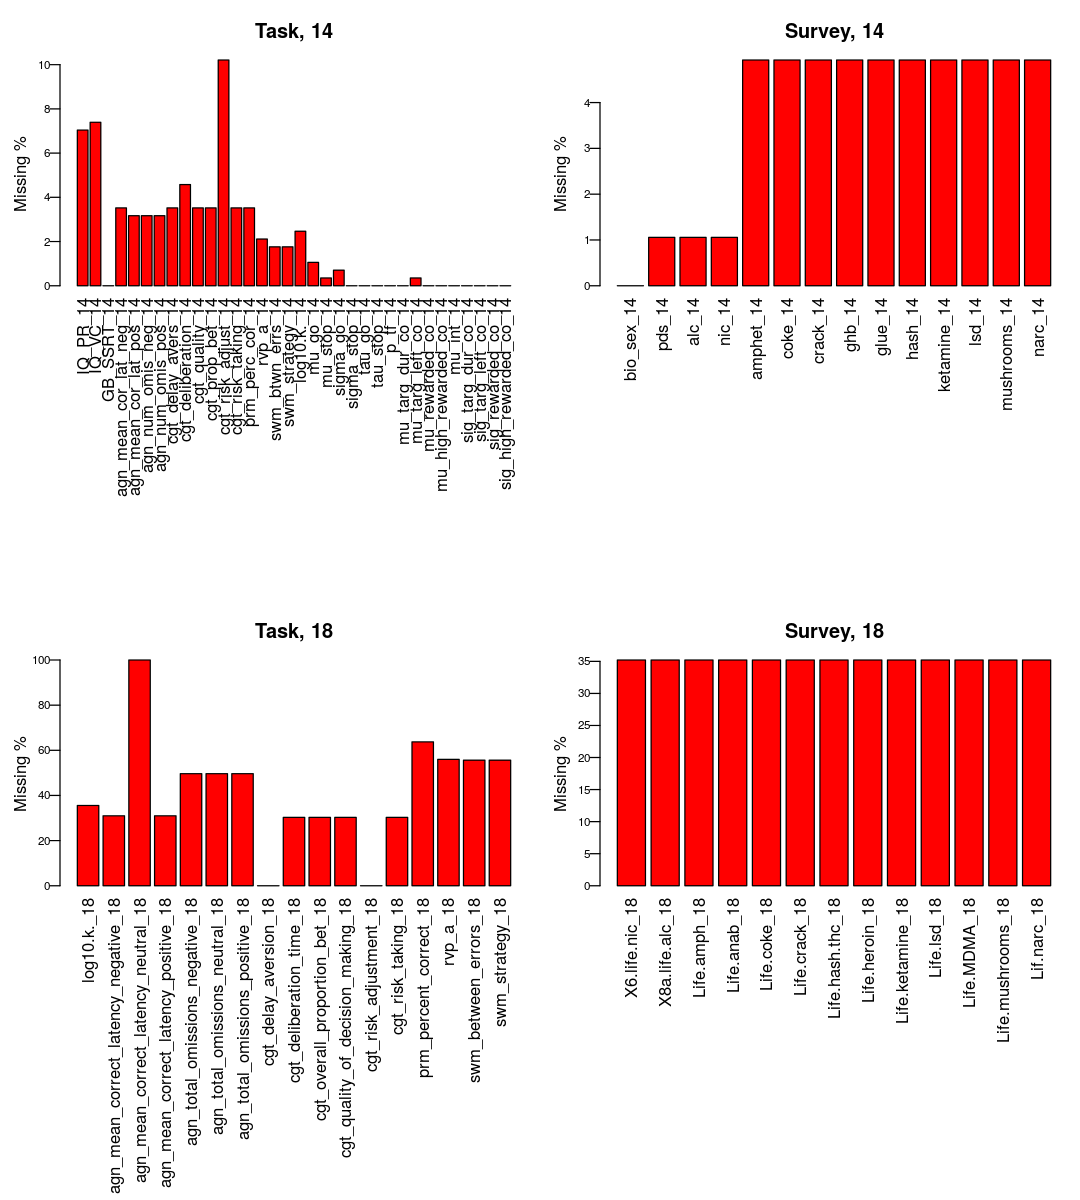

In [24]:
library(Rcpp)
library(mice)
missing_stats <- md.pattern(raw_df)

#analysis_table_file <- '/home/dan/documents/lncc/synthetic data/sst_round_2/analysis_tables.csv'
#write.csv(missing_stats, file = analysis_table_file)

get_missing_fracs <- function(data, ... ){
    result <- sapply(data, function(x) sum(is.na(x))) / dim(data)[1] * 100
    return(result)
}
                     
#options(repr.plot.width=7, repr.plot.height=7)

missing_tasks_14  <- get_missing_fracs(data_14_task.raw  )
missing_survey_14 <- get_missing_fracs(data_14_survey.raw)

missing_tasks_18  <- get_missing_fracs(data_18_task.raw  )
missing_survey_18 <- get_missing_fracs(data_18_survey.raw)

par(mfrow=c(2,2), mai = c(2.6, 0.5, 0.5, 0.1))
options(repr.plot.width=9, repr.plot.height=10)
#op <- par(mar = c(16,3,4,2))

barplot(missing_tasks_14 , col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Task, 14')
barplot(missing_survey_14, col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Survey, 14')
barplot(missing_tasks_18 , col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Task, 18')
barplot(missing_survey_18, col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Survey, 18')

## Impute Features: <a class="anchor" id="impute features"></a> ##
... using an EM algorithm for the continuous data and mean imputation for categorical data.
<br /> <br />
This uses a naive EM implementation I found on R-bloggers, which should be fine for dealing with small numbers of subjects and has the benefit (to me) of transparency.
<br /> <br />
First, the algorithm definition:

In [25]:
EMalg <- function(x, tol=.001){
    missvals <- is.na(x)
    
    new.impute <- x
    old.impute <- x
    
    count.iter <- 1
    reach.tol  <- 0
    
    sig      <- as.matrix( var(   na.exclude(x) ))
    mean.vec <- as.matrix( apply( na.exclude(x),2,mean))
 
    while(reach.tol != 1) {
        for(i in 1:nrow(x)) {
            pick.miss <-( c( missvals[i,]) )

            if ( sum(pick.miss) != 0 ) {
                inv.S <- solve(sig[!pick.miss,!pick.miss]) # we need the inverse of the covariance
 
                # Run the EM
                new.impute[i,pick.miss] <- mean.vec[pick.miss] + sig[pick.miss,!pick.miss] %*% inv.S %*%
                    (t(new.impute[i,!pick.miss])- t(t(mean.vec[!pick.miss])))
            }
        }
 
        sig <- var((new.impute))
        mean.vec <- as.matrix(apply(new.impute,2,mean))

        if(count.iter > 1){ # we don't want this to run on the first iteration or else if fails
            for(l in 1:nrow(new.impute)){
                for(m in 1:ncol(new.impute)){
                    if( abs((old.impute[l,m]-new.impute[l,m])) > tol ) {
                        reach.tol <- 0
                    } else {
                        reach.tol <- 1
                    }
                }
            }
        }
 
        count.iter <- count.iter+1 # used for debugging purposes to ensure process it iterating properly
        old.impute <- new.impute
    }
 
    return(new.impute)
}

# Impute the task features:
data_14_task.imputed <- EMalg(data_14_task.raw, tol=.0001)

# Inverting a regression of alcohol and nicotine on the espad vars would be better...
# This shouldn't be too bad though.
library(splines)
library(foreach)
library(gam)

data_14_survey.imputed <- na.gam.replace(data_14_survey.raw)
data_14_survey.imputed <- round(data_14_survey.imputed)

Loaded gam 1.14



## Clean Up Features <a class="anchor" id="clean up features"></a>##

In [26]:
# This code was for verifying the equivalence of the redundant alc and nic fields
#msk <- data_14_survey.raw['All_Nic_14'] == data_14_survey.raw['espad_6.life.nic_14']
#data_14_survey.raw[!msk,'All_Nic_14']


# Drop columns with all zeros, since they're uninformative.
data_14_survey.imputed <- data_14_survey.imputed[, colSums(data_14_survey.imputed != 0) > 0]

# Indicate which features are still a part of the data:
cat('The following survey features were dropped:\n')
setdiff(features_14_survey, colnames(data_14_survey.imputed))

cat('Hence, the following survey features are retained:\n')
print(colnames(data_14_survey.imputed))

n_feat_survey <- length(colnames(data_14_survey.imputed))
features_14_survey <- colnames(data_14_survey.imputed)

The following survey features were dropped:


[1] "amphet_14"    "coke_14"      "crack_14"     "ghb_14"       "ketamine_14" 
[6] "lsd_14"       "mushrooms_14" "narc_14"

Hence, the following survey features are retained:
[1] "bio_sex_14" "pds_14"     "alc_14"     "nic_14"     "glue_14"   
[6] "hash_14"   


No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 200 rows containing non-finite values (stat_bin).”

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1300 rows containing non-finite values (stat_bin).”

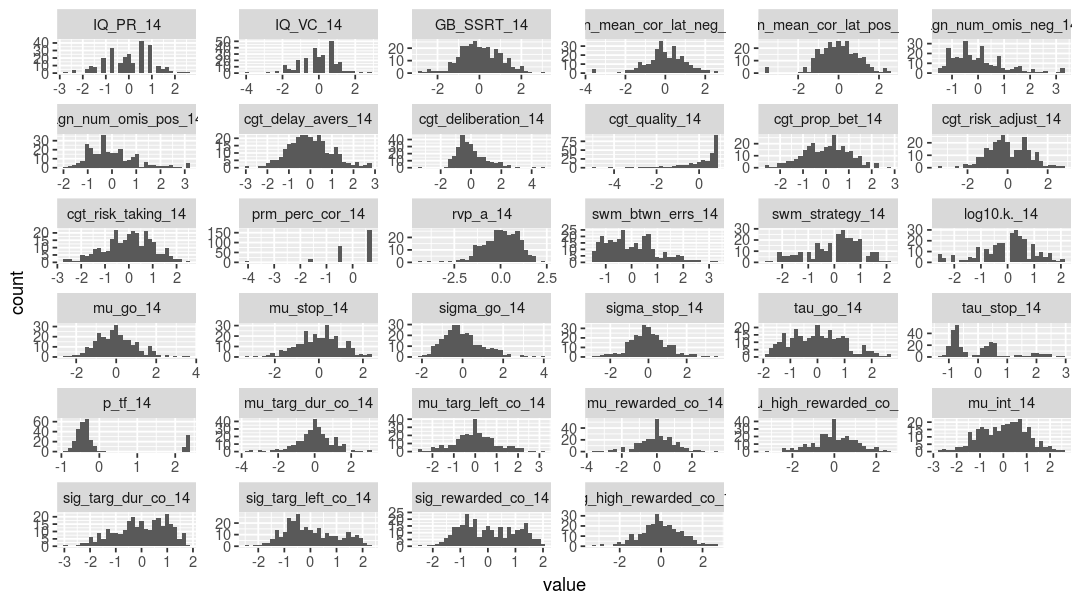

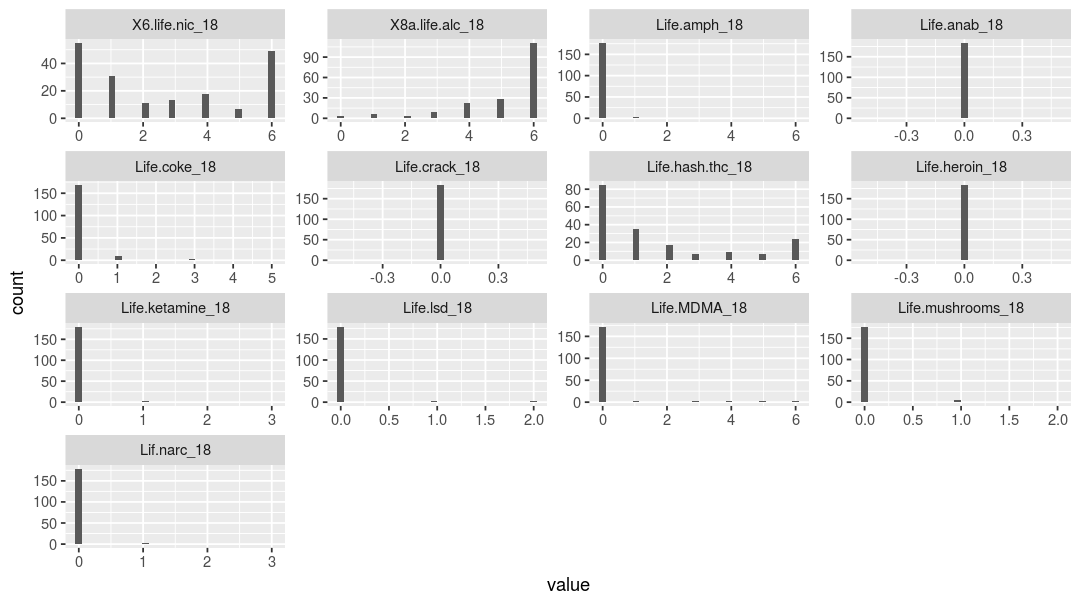

In [45]:
library(reshape2)
library(ggplot2)

options(repr.plot.width=9, repr.plot.height=5)

#d <- melt(data_14_task.imputed)
#ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_14_task.raw)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

#d <- melt(data_14_survey.raw)
#ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_18_survey.raw)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

In [46]:
# Creating imputed_df
# I must be missing something... R only hase merge for horiz. concat of data frames?
# And it requires the to-be-merged data frames to have an identical column on which to merge?
# Can there really be no horzcat()?

ncols_1 <- dim(data_14_task.imputed)[2]
ncols_2 <- dim(data_14_survey.imputed)[2]

nrows   <- dim(data_14_task.imputed)[1]

imputed_df <- data.frame(matrix(ncol=(ncols_1 + ncols_2), nrow=nrows))

imputed_df[,1:ncols_1]                     <- data_14_task.imputed
imputed_df[,(ncols_1+1):(ncols_1+ncols_2)] <- data_14_survey.imputed

colnames(imputed_df) <- c(colnames(data_14_task.imputed), colnames(data_14_survey.imputed))

dim(imputed_df)
dim(data_18_survey.raw)
#missing_imputed_df <- get_missing_fracs(imputed_df)

[1] 284  40

[1] 284  13

## Misc. Correlations  <a class="anchor" id="misc correlations"></a>##

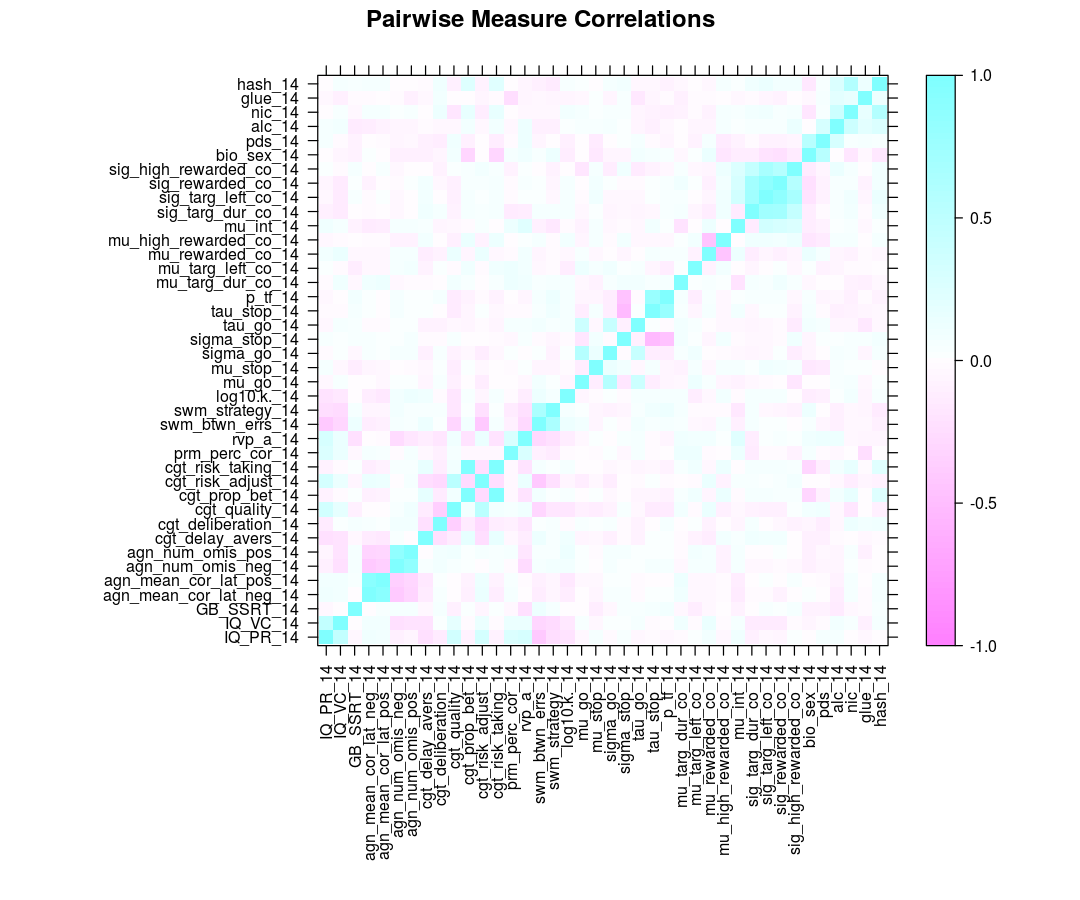

In [29]:
#pairwise_correlations <- cor(merge(data_14_task.imputed,data_14_survey.imputed))
pairwise_correlations <- cor(imputed_df)

library(lattice)
scale <- list(x=list(rot=90))
options(repr.plot.width=9, repr.plot.height=7.5)
levelplot(pairwise_correlations, scales=scale, main='Pairwise Measure Correlations'  , xlab = '', ylab = '',
         at=seq(-1, 1, length.out=100))
   #par.settings=RdBuTheme(), at=seq(-max(abs(cellStats(pairwise_correlatoins, range))),
   #                                  max(abs(cellStats(pairwise_correlations, range))), len=100))


## Canonical Correlations Analysis, Age 14  <a class="anchor" id="canonical correlations analysis age 14"></a>##

In [30]:
# Canonical Correlation Analysis:
analyze_cca <- function(dset1, dset2){

    # Setup:
    dset1_names <- colnames(dset1)
    dset2_names <- colnames(dset2)
    
    library(CCA)
    cca_res <- cancor(dset1, dset2)
    nxcoef  <- length(cca_res$xcoef[,1])
    nycoef  <- length(cca_res$ycoef[,1])

    # Set plot options
    options(repr.plot.width=9, repr.plot.height=5)
    
    # U-V Correlation Plot:
    print(cca_res$cor)
    plot(cca_res$cor,type="b", main='Task-Survey Cannonical Correlation Results',
         xlab='Canonical Covariate Index', ylab='U-V Correlation')

    # Significance testing:
    library(CCP)
    n_obs         <- dim(dset1)[1]
    n_task_vars   <- dim(dset1)[2]
    n_survey_vars <- dim(dset2)[2]

    ps <- p.asym(rho = cca_res$cor, n_obs, n_task_vars, n_survey_vars, tstat = "Wilks")
    nlines <- sum(ps$p.value < 0.05)
        
    # U Coefficients Plot:
    plotchar <- seq(18,18+nlines,1)

    xrange <- range(1:length(dset1_names))
    yrange <- range(cca_res$xcoef[,1:nlines])

    op <- par(mar=c(12.1, 4.1, 4.1, 2.1))

    plot(xrange, yrange, type="n", xlab="", ylab="Canonical Coefficient", xaxt="n")

    colors <- rainbow(nlines) 
    linetype <- c(1:nlines) 

    for (i in 1:nlines) {
      lines(1:nxcoef, cca_res$xcoef[,i], type="b", lwd=1.5, lty=linetype[1], col=colors[i], pch=plotchar[i])
    }

    # add a title and subtitle 
    title("CCA Task Coefficients")

    # add a legend
    legend(1, 50, 1:nlines, cex=0.8, col=colors, lty=linetype)
    axis(1, labels=dset1_names, at=1:length(dset1_names), las=2)
    grid()

    
    ## V Coefficients Plot:
    plotchar <- seq(18,18+nlines,1)

    xrange <- range(1:length(dset2_names)) 
    yrange <- range(cca_res$ycoef[,1:nlines])

    op <- par(mar=c(10.1, 4.1, 4.1, 2.1))
    plot(xrange, yrange, type="n", xlab="", ylab="Canonical Coefficient", xaxt="n") 

    for (i in 1:nlines) { 
      lines(1:nycoef, cca_res$ycoef[,i], type="b", lwd=1.5, lty=linetype[1], col=colors[i], pch=plotchar[i])
    }

    # add a title and subtitle 
    title("CCA Survey Coefficients")

    # add a legend
    legend(xrange[1], yrange[2], 1:nlines, cex=0.8, col=colors, lty=linetype)
    axis(1, labels=dset2_names, at=1:nycoef, las=2)
    grid()
}

Loading required package: fda
Loading required package: Matrix

Attaching package: ‘fda’

The following object is masked from ‘package:graphics’:

    matplot

Loading required package: fields
Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked _by_ ‘.GlobalEnv’:

    cleanup

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

Attaching package: ‘CCA’

The following object is masked from ‘package:mice’:

    cc



[1] 0.6013930 0.4384194 0.3935023 0.3484919 0.2991103 0.2496836
Wilks' Lambda, using F-approximation (Rao's F):
              stat    approx df1       df2      p.value
1 to 6:  0.3268780 1.4807416 204 1453.2227 4.364517e-05
2 to 6:  0.5120859 1.0685614 165 1219.0156 2.744157e-01
3 to 6:  0.6339357 0.9306672 128  981.2779 6.918845e-01
4 to 6:  0.7500813 0.8026341  93  740.1844 9.085350e-01
5 to 6:  0.8537687 0.6799807  60  496.0000 9.674205e-01
6 to 6:  0.9376581 0.5708694  29  249.0000 9.639540e-01


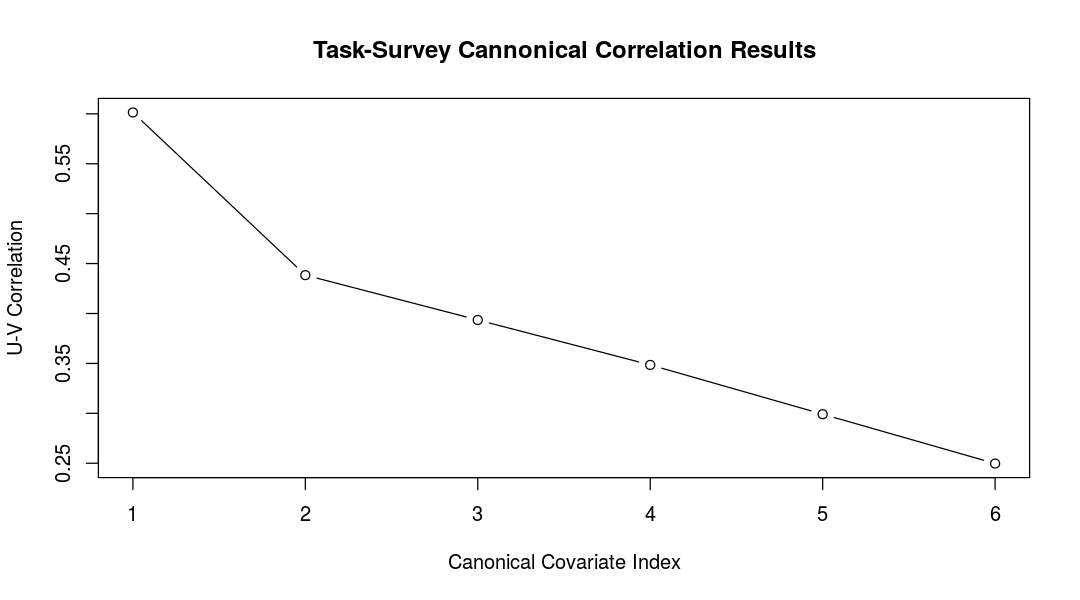

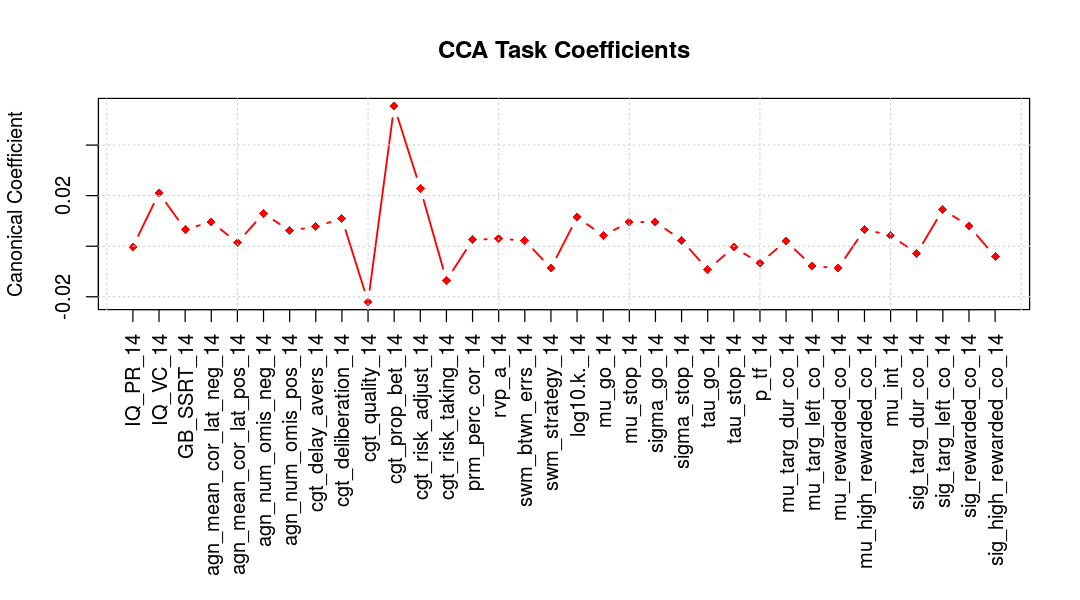

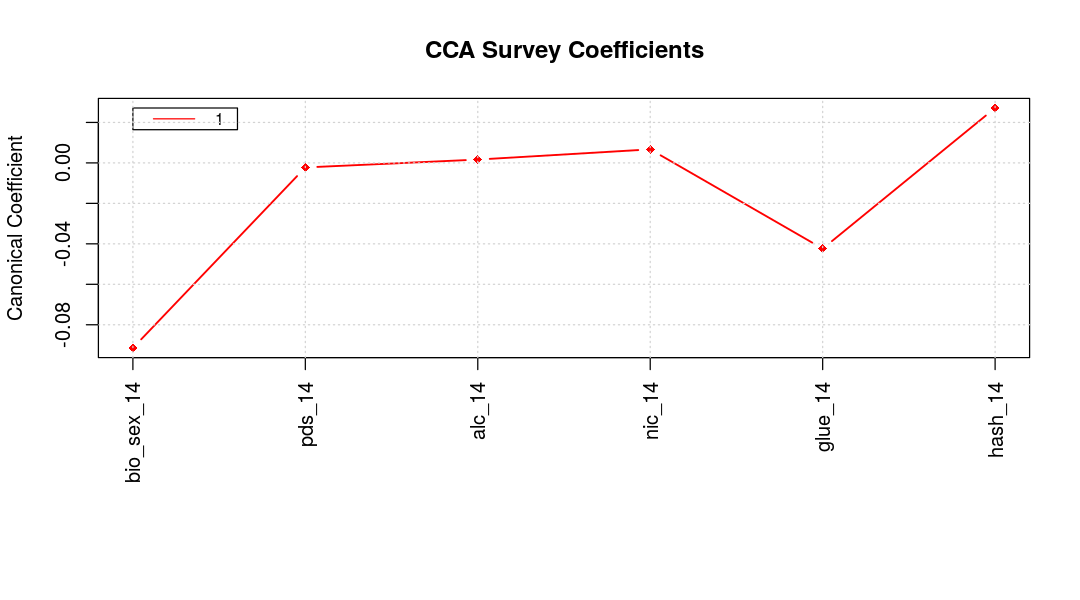

In [31]:
analyze_cca(data_14_task.imputed, data_14_survey.imputed[setdiff(colnames(data_14_survey.imputed),'age_14')])

In [32]:
#data_14_task.imputed[c('GB_SSRT_14','sigma_stop_14','mu_targ_dur_co_14')]
#data_14_survey.imputed['alc_14']

## Principle Components Analysis  <a class="anchor" id="principle components analysis"></a>##

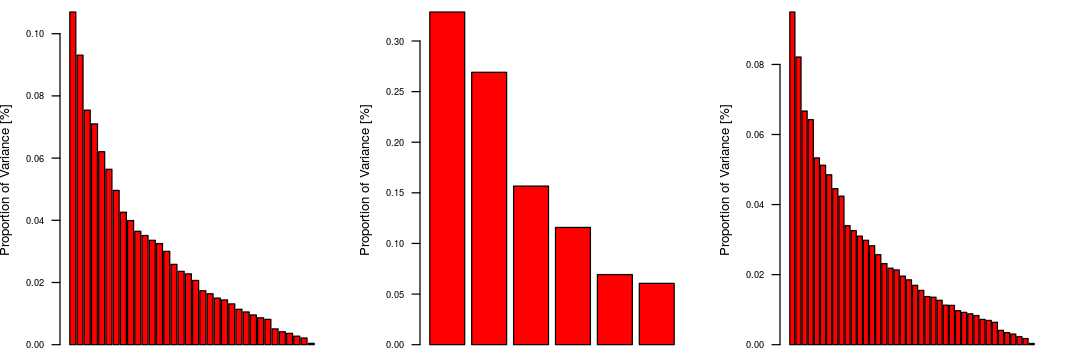

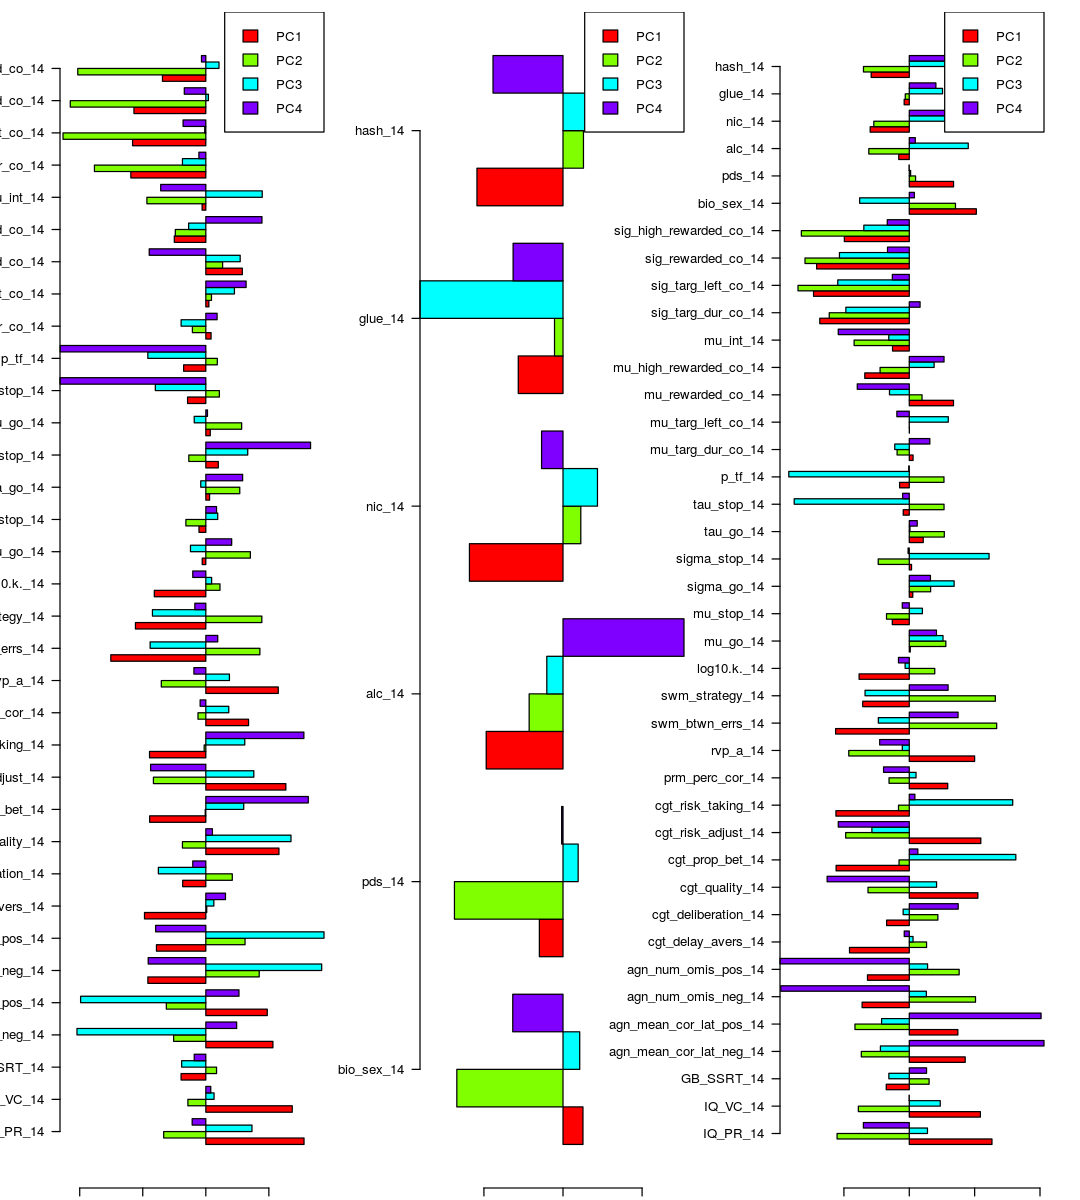

In [33]:
# Perform Task Data PCA:
task_pca      <- prcomp(data_14_task.imputed, center = TRUE, scale. = TRUE)
task_pca_pvar <- task_pca$sdev^2/sum(task_pca$sdev^2)

# Perform Survey Data PCA:
survey_pca      <- prcomp(data_14_survey.imputed, center = TRUE, scale. = TRUE)
survey_pca_pvar <- survey_pca$sdev^2/sum(survey_pca$sdev^2)

# Perform All Data PCA:
task_survey_pca      <- prcomp(imputed_df, center = TRUE, scale. = TRUE) 
task_survey_pca_pvar <- task_survey_pca$sdev^2/sum(task_survey_pca$sdev^2)


### PLOT THE VARIATION CAPTURED BY PCAs:
par(mfrow=c(1,3), mai = c(0.1, 0.5, 0.1, 0.3))
options(repr.plot.width=9, repr.plot.height=3)

ylab_top <- "Proportion of Variance [%]"

# Task PCA Plot:
barplot(task_pca_pvar,  col=c('red'), las=2, cex.axis=0.7, xlab=c('Principle Components'), ylab=ylab_top)

# Survey PCA Plot:
barplot(survey_pca_pvar,  col=c('red'), las=2, cex.axis=0.7, xlab=c('Principle Components'), ylab=ylab_top)

# Task-Survey PCA Plot: 
barplot(task_survey_pca_pvar,  col=c('red'), las=2, cex.axis=0.7, 
        xlab=c('Principle Components'), ylab=c("Proportion of Variance [%]"))


## PLOT THE LOADINGS FOR EACH PCA:
par(mfrow=c(1,3), mai = c(0.1, 0.5, 0.1, 0.3))
options(repr.plot.width=9, repr.plot.height=10)

barplot(t(task_pca$rotation[,1:4]), main="", horiz=TRUE, beside=TRUE, col=rainbow(4), yaxt='n')
axis(2, labels=colnames(data_14_task.imputed), at=seq(3,n_feat_task*5,by=5), las=2)
legend("topright", legend=c('PC1', 'PC2', 'PC3', 'PC4'), fill = rainbow(4))

barplot(t(survey_pca$rotation[,1:4]), main="", horiz=TRUE, beside=TRUE, col=rainbow(4), yaxt='n')
axis(2, labels=colnames(data_14_survey.imputed), at=seq(3,n_feat_survey*5,by=5), las=2)
legend("topright", legend=c('PC1', 'PC2', 'PC3', 'PC4'), fill = rainbow(4))

barplot(t(task_survey_pca$rotation[,1:4]), main="", horiz=TRUE, beside=TRUE, col=rainbow(4), yaxt='n')
axis(2, labels=colnames(imputed_df), at=seq(3,(n_feat_task + n_feat_survey)*5,by=5), las=2)
legend("topright", legend=c('PC1', 'PC2', 'PC3', 'PC4'), fill = rainbow(4))

## CCA Across Baseline and Follow Up <a class="anchor" id="cca across baseline and follow up"></a>##
Double check that the imputed data and the age 18 survey data can still be used properly in case of shuffle.

In [34]:
dim(imputed_df[complete.cases(raw_df[,'X8a.life.alc_18']),])[1] == 
    dim(data_18_survey.raw[complete.cases(data_18_survey.raw[,'X8a.life.alc_18']),])[1]

[1] TRUE

#### Drop rows without age 18 Survey Data ###

In [35]:
imputed_df <- imputed_df[complete.cases(raw_df[,'X8a.life.alc_18']),]
imputed_df <- imputed_df[, colSums(imputed_df != 0) > 0]


data_18_survey <- data_18_survey.raw[complete.cases(data_18_survey.raw[,'X8a.life.alc_18']),]
data_18_survey <- data_18_survey[, colSums(data_18_survey != 0) > 0]

dim(imputed_df)
dim(data_18_survey)

#missing_imputed_df     <- get_missing_fracs(imputed_df)
#missing_data_18_survey <- get_missing_fracs(data_18_survey)
#missing_imputed_df
#missing_data_18_survey

[1] 184  40

[1] 184  10

In [36]:
if (shuffle) {
    cnames <- features_18_survey
    for (i in 1:length(cnames)) {
        col  <- cnames[i]
        perm <- sample(1:dim(data_18_survey)[1], replace=TRUE)
        data_18_survey[col] <- data_18_survey[perm,col]
    }
}

 [1] 0.6820407 0.6398398 0.5856104 0.5338877 0.5037131 0.4688033 0.4158528
 [8] 0.3531307 0.3287040 0.3051980
Wilks' Lambda, using F-approximation (Rao's F):
                 stat    approx df1       df2    p.value
1 to 10:   0.05059272 1.1964791 400 1331.2073 0.01149856
2 to 10:   0.09459756 1.0606792 351 1208.8376 0.24004127
3 to 10:   0.16017058 0.9381811 304 1083.9952 0.74971428
4 to 10:   0.24376842 0.8398140 259  956.6663 0.95663227
5 to 10:   0.34095204 0.7617233 216  826.8567 0.99242074
6 to 10:   0.45687298 0.6791676 175  694.5981 0.99897485
7 to 10:   0.58556685 0.5924821 136  559.9560 0.99986070
8 to 10:   0.70800459 0.5223917  99  423.0384 0.99992753
9 to 10:   0.80887196 0.4964924  64  284.0000 0.99946010
10 to 10:  0.90685419 0.4738056  31  143.0000 0.99148339


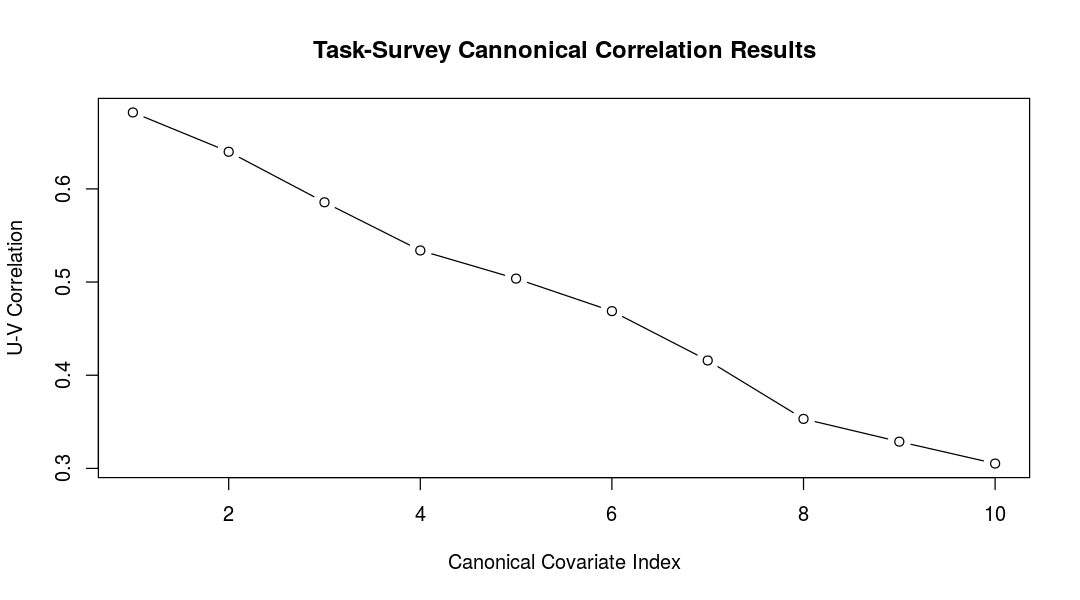

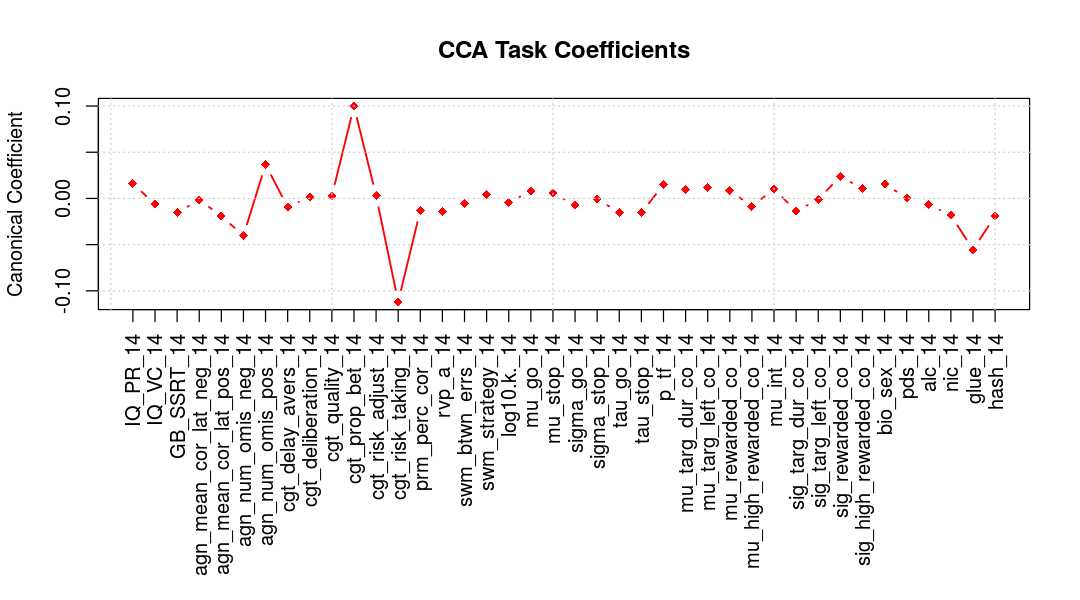

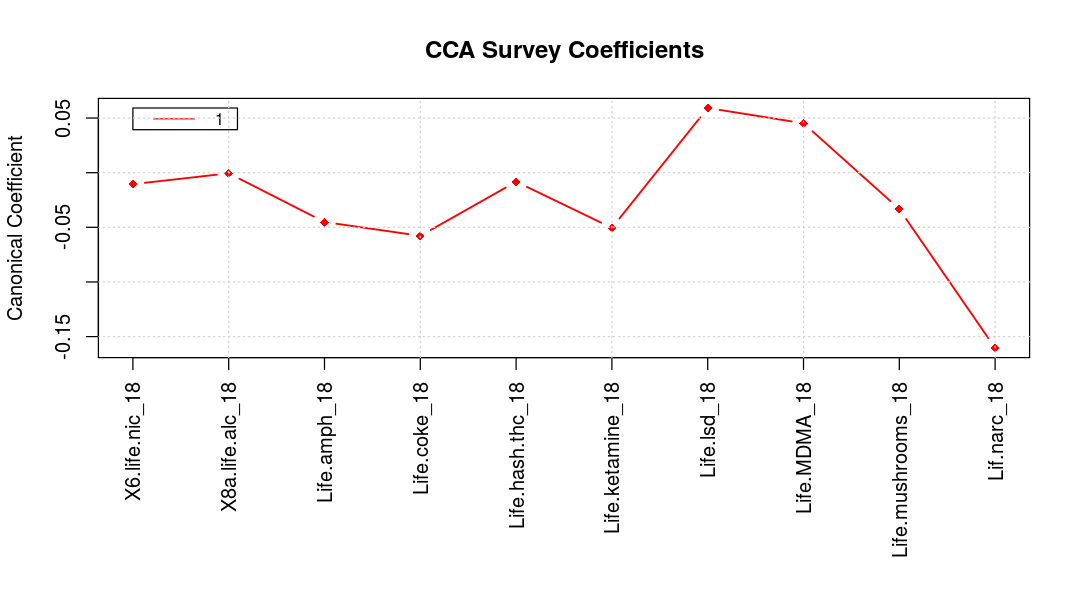

In [37]:
analyze_cca(imputed_df, data_18_survey)

## CCA From Age 14 Tasks to Age 18 Survey <a class="anchor" id="cca from age 14 tasks to age 18 survey"></a>##

In [38]:
colSums(data_18_survey)
#'Life.GHB_18','Life.tranq_18','Life.glue_18'

colSums(data_14_survey.imputed)
#'anabolic_14','mdma_14','tranq_14','heroin_14'

X6.life.nic_18   X8a.life.alc_18      Life.amph_18      Life.coke_18 
              493               937                19                27 
 Life.hash.thc_18  Life.ketamine_18       Life.lsd_18      Life.MDMA_18 
              305                 7                 8                45 
Life.mushrooms_18       Lif.narc_18 
                8                 8

bio_sex_14     pds_14     alc_14     nic_14    glue_14    hash_14 
       137       1015        594        173         16         45

In [39]:
row_sums <- rowSums(data_18_survey[c(setdiff(colnames(data_18_survey),c('age_18','X6.life.nic_18','X8a.life.alc_18')))])

In [40]:
new_df <- data_18_survey[c('X6.life.nic_18','X8a.life.alc_18')]
new_df['cum_other_18'] <- row_sums
head(new_df)
dim(new_df)
dim(imputed_df)

,X6.life.nic_18,X8a.life.alc_18,cum_other_18
2,3,6,2
3,0,6,2
4,4,6,2
5,6,6,1
6,0,1,0
7,4,6,0


[1] 184   3

[1] 184  40

 [1] 0.5580058 0.5544920 0.4648113 0.4117616 0.3862600 0.3632058 0.3328271
 [8] 0.2717454 0.2478930 0.1772473
Wilks' Lambda, using F-approximation (Rao's F):
                stat    approx df1       df2    p.value
1 to 10:   0.1716771 1.1770013 250 1413.2475 0.04150773
2 to 10:   0.2493025 1.0647981 216 1288.7103 0.26344121
3 to 10:   0.3599835 0.9094578 184 1160.9513 0.79057897
4 to 10:   0.4591917 0.8234566 154 1029.7350 0.93585896
5 to 10:   0.5529416 0.7639856 126  894.8168 0.97120063
6 to 10:   0.6499054 0.6981291 100  755.9565 0.98746682
7 to 10:   0.7486686 0.6149738  76  612.9435 0.99543133
8 to 10:   0.8419328 0.5125778  54  465.6349 0.99843297
9 to 10:   0.9090631 0.4509124  34  314.0000 0.99686862
10 to 10:  0.9685834 0.3203018  16  158.0000 0.99427531


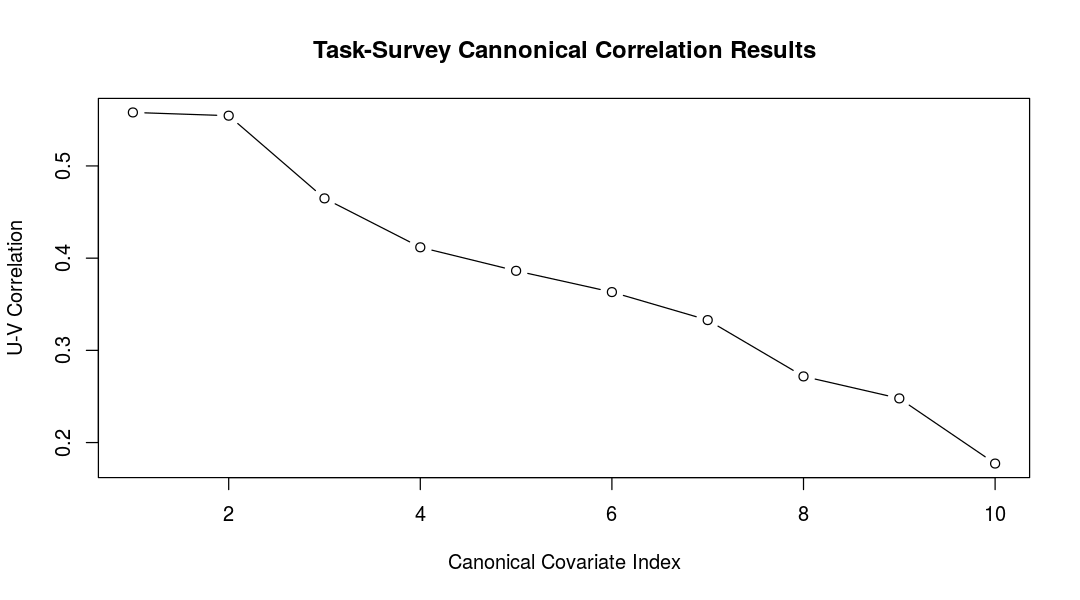

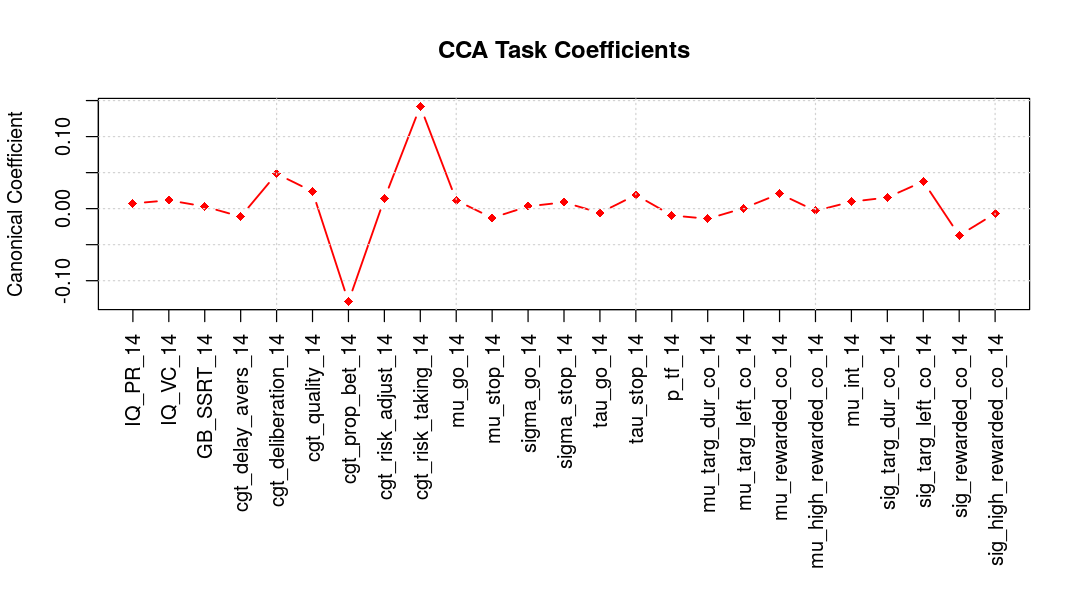

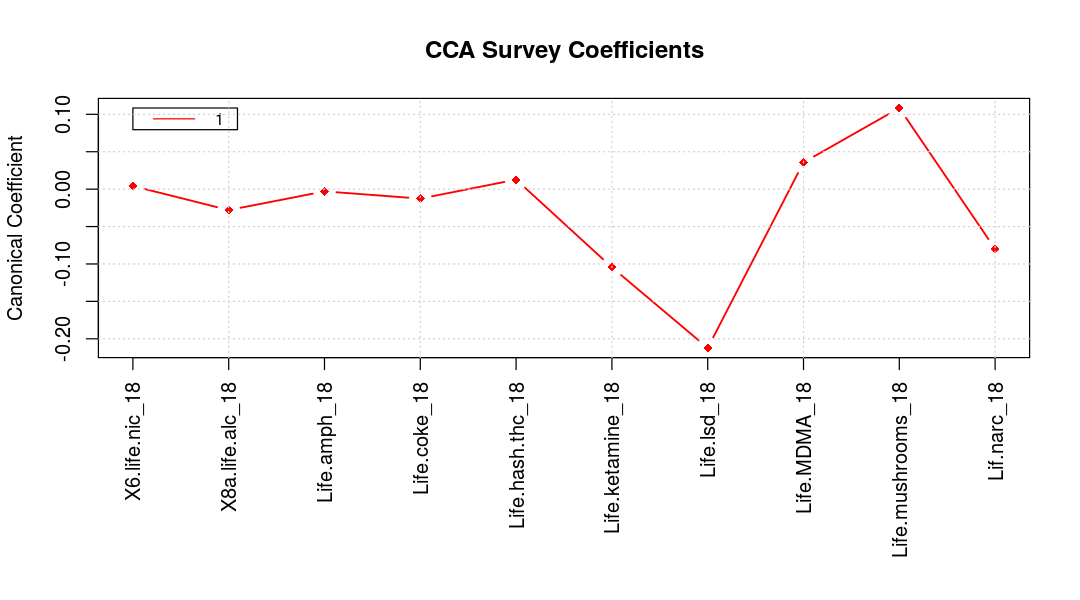

In [44]:
#head(imputed_df[features_14_task])
analyze_cca(imputed_df[c('IQ_PR_14', 'IQ_VC_14', 'GB_SSRT_14',
       'cgt_delay_avers_14',
       'cgt_deliberation_14',
       'cgt_quality_14',
       'cgt_prop_bet_14',
       'cgt_risk_adjust_14',
       'cgt_risk_taking_14',
       'mu_go_14', 'mu_stop_14', 'sigma_go_14','sigma_stop_14','tau_go_14','tau_stop_14','p_tf_14',
       'mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
       'mu_high_rewarded_co_14', 'mu_int_14',
       'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
       'sig_high_rewarded_co_14')], data_18_survey[c(setdiff(colnames(data_18_survey),c('age_18')))])

In [ ]:
#analyze_cca(imputed_df[features_14_survey], data_18_survey)
rando <- sample(1:250)

In [ ]:
fairly_heavy_msk <- new_df['cum_other_18'] >= 4
sum(fairly_heavy_msk, na.rm=T)
dim(raw_df[features_14_task])

fairly_heavy_msk <- factor(as.numeric(fairly_heavy_msk[1:250]))
#raw_df[features_14_task][rando,]

feature_list <- c('IQ_PR_14', 'IQ_VC_14', 'GB_SSRT_14','cgt_delay_avers_14',
       'agn_mean_cor_lat_neg_14',
       'agn_mean_cor_lat_pos_14',
       'agn_num_omis_neg_14',
       'agn_num_omis_pos_14',
       'cgt_deliberation_14',
       'cgt_quality_14',
       'cgt_prop_bet_14',
       'cgt_risk_adjust_14',
       'cgt_risk_taking_14',
       'mu_go_14', 'mu_stop_14', 'sigma_go_14','sigma_stop_14','tau_go_14','tau_stop_14','p_tf_14',
       'mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
       'mu_high_rewarded_co_14', 'mu_int_14',
       'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
       'sig_high_rewarded_co_14')

feats <- raw_df[feature_list]
feats <- feats[rand,]
labs  <- fairly_heavy_msk[rand]

library(e1071)
classifier <- naiveBayes(feats, labs, na.action=na.pass)
table(predict(classifier, feats), labs, dnn=list('predicted','actual'))
#preds <- predict(classifier,feats)

In [ ]:
options(repr.plot.width=9, repr.plot.height=4)

clusters <- hclust(dist(feats))
plot(clusters)

clusters <- hclust(dist(imputed_df))
plot(clusters, xlab="Subjects")

In [ ]:
cgt_to_18_df <- cbind(imputed_df[c(
       'cgt_delay_avers_14',
       'cgt_deliberation_14',
       'cgt_quality_14',
       'cgt_prop_bet_14',
       'cgt_risk_adjust_14',
       'cgt_risk_taking_14')],
        data_18_survey)


#pairwise_correlations <- cor(merge(data_14_task.imputed,data_14_survey.imputed))
pairwise_correlations <- cor(cgt_to_18_df)

library(lattice)
scale <- list(x=list(rot=90))
options(repr.plot.width=5, repr.plot.height=5)
levelplot(pairwise_correlations, scales=scale, main='Task-Survey Correlations'  , xlab = '', ylab = '',
         at=seq(-1, 1, length.out=100))

## Gaussian Mixture Model <a class="anchor" id="gaussian mixture model"></a> ##

In [ ]:
library(rtkore)
library(MixAll)

#model <- list()
#for (i in 1:7) {
#    model[[i]] <- clusterDiagGaussian(data=imputed_df, nbCluster=i, strategy = clusterFastStrategy())
#    summary(model[[i]])
#}

# Misc. Info #

## Description of the CANTAB Measures ##
Participants completed five of the CANTAB tests. 

**The Affective Go/No-go** task comprised of alternating blocks in which participants were presented with positively or negatively valenced target words embedded in a stream of neutral distracter words. Participants were instructed to respond to targets with a button press.  Measures included in the analyses were the total number of omissions to positive and negative targets, and the average response latency to positive and negative target words.
- 'agn_mean_correct_latency_negative'  Measure is average RT to negative targets
- 'agn_mean_correct_latency_positive' Measure is average RT to positive targets
- 'agn_total_omissions_negative' Measure is number of negatively valenced target words that the participant failed to respond to 
- 'agn_total_omissions_positive' Measure is number of positively valenced target words that the participant failed to respond to 

<br />
In the **Pattern Recognition Memory** task participants were required to remember 12 abstract patterns; the percentage of patterns correctly recognized on a two alternative forced choice task completed immediately after encoding was included in the analyses. 
- 'prm_percent_correct'  Score reflects % correct

<br />
**The Spatial Working Memory Task** required participants to “search” for a token hidden by one of a number of boxes on the monitor by selecting the boxes in sequence. Once the token is uncovered, participants must search again with the condition that the token will not be hidden in the same location more than once. The number of times participants returned to search a box that had already contained the token was entered into the analyses as an error measure. We also included a strategy score (ranging from 1-37, with lower scores indicating a more strategic approach), which reflects how often a search sequence was initiated from a novel position.
- 'swm_between_errors':  Score reflects the number of times the child revisits a box that has already been shown to contain a token (higher scores represent less efficiency).
- 'swm_strategy': For displays with more than 6 boxes, this measure represents the number of boxes in which the child initiates a new search within the same display (higher scores represent a less strategic approach).

<br />
**The Rapid Visual Information Processing** task comprised of a stream of digits presented at 1.67Hz and participants were required to monitor the stream for target sequence of three digits. We included a signal detection measure of sensitivity to the target sequence in the analyses. 
- 'rvp_a'  Score is a signal detection measure reflecting ability to discriminate a target sequence of 3 digits embedded in a rapidly presented stream.

<br />
**The Cambridge Guessing Task (CGT)** was a modified version of the Cambridge Gambling Task, renamed in order to make it appropriate to administer to adolescents.  On each trial of the CGT the participant was presented with 10 boxes, some of which are blue, some of which are red, and must “guess” which color box conceals a hidden yellow token.  Participants start the task with 100 points and lose or acquire points by wagering on their guess.  The options the participant can choose to wager are determined by the program as a proportion of their total number of points, presented in either increasing or decreasing amounts.  Measures included the time taken to select the option on which to bet, an average of the proportion of the total number of points wagered on each trial, the proportion of trials on which the more likely outcome was selected (quality of decision making), an average of the proportion wagered on trials when the participant selected the more likely result (rational bets), risk adjustment assessed by variation in the amount wagered in response to the ratio of red to blue boxes, and an index of delay aversion reflected in making higher bets when the amount to bet is presented in descending order rather than in ascending order.
- 'cgt_delay_aversion'  Delay aversion is a measure of the particicipant's preference for making higher bets when the amount to wager is presented in descending (rather than ascending) order.
- 'cgt_deliberation_time' Deliberation time is the time taken to select an amount to wager.
- 'cgt_quality_of_decision_making' Proportion of trials on which the more likely outcome was selected
- 'cgt_overall_proportion_bet' The average of the proportion of the participant's current kitty that is wagered on each trial
- 'cgt_risk_adjustment' The degree to which the proportion bet is affected by the ratio of red:blue boxes on every trial, accounting for the overall proportion bet. (N.B. This measure is not available at baseline for 1 site)
- 'cgt_risk_taking' The average of the proportion of the participant's current kitty that is wagered on each trial, but only for those trials on which they selected the more likely option.

## Shuffle Test Results: ##
#### Within Age 14 CCA Power: ####
```
Wilks' Lambda, using F-approximation (Rao's F):
               stat    approx df1      df2   p.value
1 to 9:  0.05852855 1.1033115 333 960.1558 0.1322570
2 to 9:  0.11151498 0.9690324 288 862.3459 0.6216398
3 to 9:  0.17943291 0.8828510 245 762.2388 0.8786514
4 to 9:  0.27057057 0.7990811 204 659.8290 0.9724989
5 to 9:  0.38573295 0.7132859 165 555.1334 0.9951440
6 to 9:  0.50555028 0.6549245 128 448.1989 0.9977287
7 to 9:  0.65571569 0.5521529  93 339.1112 0.9995903
8 to 9:  0.80497602 0.4353775  60 228.0000 0.9998807
9 to 9:  0.92688677 0.3128017  29 115.0000 0.9996957
```
#### Between Age CCA Power: ####
```
Wilks' Lambda, using F-approximation (Rao's F):
                   stat    approx df1      df2   p.value
1 to 13:   4.648266e-05 1.0510620 598 516.0380 0.2798270
2 to 13:   2.278570e-04 0.9526798 540 485.5283 0.7086996
3 to 13:   9.090377e-04 0.8676351 484 453.4905 0.9378439
4 to 13:   3.152975e-03 0.7861091 430 419.9120 0.9933843
5 to 13:   8.448730e-03 0.7318777 378 384.7831 0.9988092
6 to 13:   2.130388e-02 0.6701743 328 348.0984 0.9998712
7 to 13:   4.513821e-02 0.6265407 280 309.8584 0.9999642
8 to 13:   8.406626e-02 0.5969701 234 270.0713 0.9999722
9 to 13:   1.470997e-01 0.5671649 190 228.7545 0.9999703
10 to 13:  2.507534e-01 0.5215760 148 185.9380 0.9999776
11 to 13:  4.020678e-01 0.4664280 108 141.6664 0.9999783
12 to 13:  5.865495e-01 0.4192632  70  96.0000 0.9999109
13 to 13:  7.951993e-01 0.3711699  34  49.0000 0.9984572
```